<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [2]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2020-01-09 00:27:55--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

100%[======================================>] 23,101      --.-K/s   in 0.002s  

2020-01-09 00:27:55 (13.1 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape

(346, 10)

### Convert to date time object 

In [5]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [6]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [7]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

Solving environment: done

# All requested packages already installed.



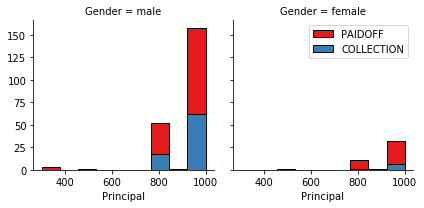

In [8]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

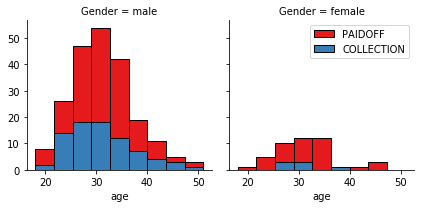

In [9]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

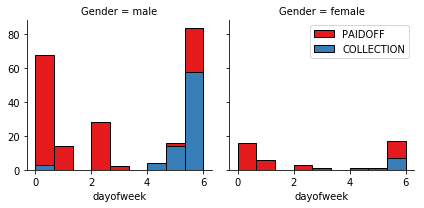

In [10]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [11]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [12]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [13]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [14]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature before One Hot Encoding

In [15]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [16]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Lets defind feature sets, X:

In [17]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?

In [18]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [19]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':


array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

In [20]:
#train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=0)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


In [21]:
#import KNN library
from sklearn.neighbors import KNeighborsClassifier

#calculate KNN accuracy for different k's
from sklearn import metrics
Ks = 11
mean_acc_train = np.zeros((Ks-1))
std_acc_train = np.zeros((Ks-1))
mean_acc_test = np.zeros((Ks-1))
std_acc_test = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    
    #training set predicted labels
    yhat_train = neigh.predict(X_train)
    
    #test set predicted labels
    yhat_test = neigh.predict(X_test)
    
    #get training accuracy
    mean_acc_train[n-1] = metrics.accuracy_score(y_train, yhat_train)
    std_acc_train[n-1] = np.std(yhat_train==y_train)/np.sqrt(yhat_train.shape[0])
    
    #get test accuracy
    mean_acc_test[n-1] = metrics.accuracy_score(y_test, yhat_test)
    std_acc_test[n-1]= np.std(yhat_test==y_test)/np.sqrt(yhat_test.shape[0])

print('experimented ks:', np.arange(1,Ks))
print("Train set Accuracy: ", mean_acc_train)
print("Test set Accuracy: ", mean_acc_test)

experimented ks: [ 1  2  3  4  5  6  7  8  9 10]
Train set Accuracy:  [0.89855072 0.84057971 0.84057971 0.81884058 0.8115942  0.80797101
 0.80072464 0.78985507 0.7826087  0.78623188]
Test set Accuracy:  [0.65714286 0.57142857 0.7        0.67142857 0.71428571 0.68571429
 0.75714286 0.72857143 0.75714286 0.68571429]


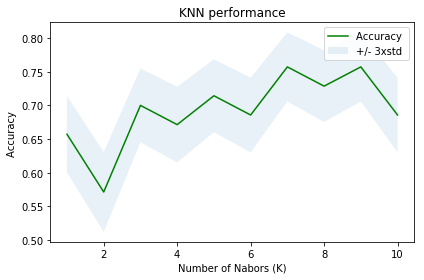

In [22]:
#plot model accuracy with different k's
plt.plot(range(1,Ks),mean_acc_test,'g')
plt.fill_between(range(1,Ks),mean_acc_test - 1 * std_acc_test,mean_acc_test + 1 * std_acc_test, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Nabors (K)')
plt.title('KNN performance')
plt.tight_layout()
plt.show()

In [23]:
print( "The best KNN accuracy was ", mean_acc_test.max(), "with k=", mean_acc_test.argmax()+1) 

The best KNN accuracy was  0.7571428571428571 with k= 7


# Decision Tree

In [34]:
#import Decision Tree library
from sklearn.tree import DecisionTreeClassifier

#calculate Decision Tree accuracy for different tree depths
from sklearn import metrics
max_depths = 11
mean_acc_train = np.zeros((max_depths-1))
std_acc_train = np.zeros((max_depths-1))
mean_acc_test = np.zeros((max_depths-1))
std_acc_test = np.zeros((max_depths-1))
ConfustionMx = [];
for n in range(1,max_depths):
    
    #Train Model and Predict  
    dt = DecisionTreeClassifier(criterion="entropy", max_depth = n)
    dt.fit(X_train,y_train)
    
    #training set predicted labels
    yhat_train = dt.predict(X_train)
    
    #test set predicted labels
    yhat_test = dt.predict(X_test)
    
    #get training accuracy
    mean_acc_train[n-1] = metrics.accuracy_score(y_train, yhat_train)
    std_acc_train[n-1] = np.std(yhat_train==y_train)/np.sqrt(yhat_train.shape[0])
    
    #get test accuracy
    mean_acc_test[n-1] = metrics.accuracy_score(y_test, yhat_test)
    std_acc_test[n-1]= np.std(yhat_test==y_test)/np.sqrt(yhat_test.shape[0])

print('experimented tree depths:', np.arange(1,max_depths))
print("Train set Accuracy: ", mean_acc_train)
print("Test set Accuracy: ", mean_acc_test)

experimented tree depths: [ 1  2  3  4  5  6  7  8  9 10]
Train set Accuracy:  [0.73188406 0.73188406 0.73188406 0.73913043 0.76086957 0.77173913
 0.80072464 0.81884058 0.86231884 0.88043478]
Test set Accuracy:  [0.82857143 0.82857143 0.82857143 0.71428571 0.8        0.72857143
 0.74285714 0.72857143 0.72857143 0.65714286]


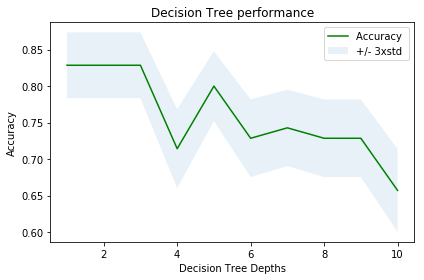

In [25]:
#plot model accuracy with different decision tree depths
plt.plot(range(1,max_depths),mean_acc_test,'g')
plt.fill_between(range(1,max_depths),mean_acc_test - 1 * std_acc_test,mean_acc_test + 1 * std_acc_test, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy')
plt.xlabel('Decision Tree Depths')
plt.title('Decision Tree performance')
plt.tight_layout()
plt.show()

In [26]:
print( "The best Decision Tree accuracy was ", mean_acc_test.max(), "with decision tree depth =", mean_acc_test.argmax()+1) 

The best Decision Tree accuracy was  0.8285714285714286 with decision tree depth = 1


# Support Vector Machine

In [37]:
#import SVM library
from sklearn import svm

#calculate SVM accuracy for different c's (Regularization parameter)
from sklearn import metrics
cs = 6
mean_acc_train = np.zeros((cs-(-5)))
std_acc_train = np.zeros((cs-(-5)))
mean_acc_test = np.zeros((cs-(-5)))
std_acc_test = np.zeros((cs-(-5)))
ConfustionMx = [];
for n in range(-5,cs):
    
    #Train Model and Predict  
    supportvecm = svm.SVC(kernel='rbf',C=np.float_power(10,n),gamma='auto')
    supportvecm.fit(X_train, y_train) 
    
    #training set predicted labels
    yhat_train = supportvecm.predict(X_train)
    
    #test set predicted labels
    yhat_test = supportvecm.predict(X_test)
    
    #get training accuracy
    mean_acc_train[n-1] = metrics.accuracy_score(y_train, yhat_train)
    std_acc_train[n-1] = np.std(yhat_train==y_train)/np.sqrt(yhat_train.shape[0])
    
    #get test accuracy
    mean_acc_test[n-1] = metrics.accuracy_score(y_test, yhat_test)
    std_acc_test[n-1]= np.std(yhat_test==y_test)/np.sqrt(yhat_test.shape[0])

print('experimented regularization parameter cs:', np.float_power(10,np.arange(-5,cs)))
print("Train set Accuracy: ", mean_acc_train)
print("Test set Accuracy: ", mean_acc_test)

experimented regularization parameter cs: [1.e-05 1.e-04 1.e-03 1.e-02 1.e-01 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04
 1.e+05]
Train set Accuracy:  [0.80072464 0.83333333 0.85507246 0.86231884 0.88043478 0.73188406
 0.73188406 0.73188406 0.73188406 0.73188406 0.7826087 ]
Test set Accuracy:  [0.7        0.68571429 0.7        0.72857143 0.78571429 0.82857143
 0.82857143 0.82857143 0.82857143 0.82857143 0.71428571]


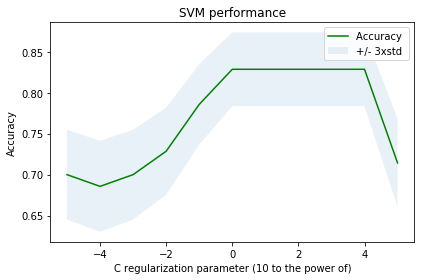

In [28]:
#plot model accuracy with different c's (Regularization parameter)
plt.plot(range(-5,cs),mean_acc_test,'g')
plt.fill_between(range(-5,cs),mean_acc_test - 1 * std_acc_test,mean_acc_test + 1 * std_acc_test, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy')
plt.xlabel('C regularization parameter (10 to the power of)')
plt.title('SVM performance')
plt.tight_layout()
plt.show()

In [32]:
print( "The best SVM accuracy was ", mean_acc_test.max(), "with SVM regularization parameter c =", np.float_power(10,-5+mean_acc_test.argmax())) 

The best SVM accuracy was  0.8285714285714286 with SVM regularization parameter c = 1.0


# Logistic Regression

In [38]:
#import logistic regression library
from sklearn.linear_model import LogisticRegression

#calculate Logistic Regression accuracy for different c's (Inverse of regularization strength)
from sklearn import metrics
cs = 6
mean_acc_train = np.zeros((cs-(-5)))
std_acc_train = np.zeros((cs-(-5)))
mean_acc_test = np.zeros((cs-(-5)))
std_acc_test = np.zeros((cs-(-5)))
ConfustionMx = [];
for n in range(-5,cs):
    
    #Train Model and Predict  
    lr = LogisticRegression(C=np.float_power(10,n), solver='liblinear')
    lr.fit(X_train,y_train)
    
    #training set predicted labels
    yhat_train = lr.predict(X_train)
    
    #test set predicted labels
    yhat_test = lr.predict(X_test)
    
    #get training accuracy
    mean_acc_train[n-1] = metrics.accuracy_score(y_train, yhat_train)
    std_acc_train[n-1] = np.std(yhat_train==y_train)/np.sqrt(yhat_train.shape[0])
    
    #get test accuracy
    mean_acc_test[n-1] = metrics.accuracy_score(y_test, yhat_test)
    std_acc_test[n-1]= np.std(yhat_test==y_test)/np.sqrt(yhat_test.shape[0])

print('experimented Inverse of regularization strength cs:', np.float_power(10,np.arange(-5,cs)))
print("Train set Accuracy: ", mean_acc_train)
print("Test set Accuracy: ", mean_acc_test)

experimented Inverse of regularization strength cs: [1.e-05 1.e-04 1.e-03 1.e-02 1.e-01 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04
 1.e+05]
Train set Accuracy:  [0.72101449 0.72101449 0.72101449 0.72101449 0.72101449 0.69927536
 0.69927536 0.70289855 0.73550725 0.73188406 0.72101449]
Test set Accuracy:  [0.82857143 0.82857143 0.82857143 0.82857143 0.82857143 0.77142857
 0.77142857 0.78571429 0.8        0.82857143 0.84285714]


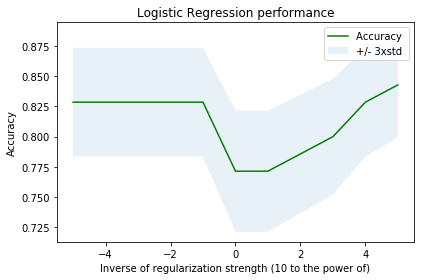

In [39]:
#plot model accuracy with different c's (Inverse of regularization strength)
plt.plot(range(-5,cs),mean_acc_test,'g')
plt.fill_between(range(-5,cs),mean_acc_test - 1 * std_acc_test,mean_acc_test + 1 * std_acc_test, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy')
plt.xlabel('Inverse of regularization strength (10 to the power of)')
plt.title('Logistic Regression performance')
plt.tight_layout()
plt.show()

In [42]:
print( "The best Logistic Regression accuracy was ", mean_acc_test.max(), "with Inverse of regularization strength parameter c =", np.float_power(10,-5+mean_acc_test.argmax())) 

The best Logistic Regression accuracy was  0.8428571428571429 with Inverse of regularization strength parameter c = 100000.0


# Model Evaluation using Test set

In [43]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:

In [44]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2020-01-09 01:14:38--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

100%[======================================>] 3,642       --.-K/s   in 0s      

2020-01-09 01:14:38 (388 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation 

In [45]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [46]:
#convert to date time object 
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,female
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,male
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,male


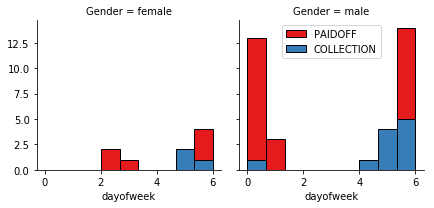

In [47]:
#look at the day of the week people get the loan 
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
bins = np.linspace(test_df.dayofweek.min(), test_df.dayofweek.max(), 10)
g = sns.FacetGrid(test_df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

In [48]:
#Use Feature binarization to set a threshold values less then day 4 
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,female,3,0
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,male,4,1
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,female,5,1
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,male,5,1
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,male,6,1


In [49]:
#Convert Categorical features to numerical values
test_df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,1,3,0
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,0,4,1
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,1,5,1
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,0,5,1
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,0,6,1


In [50]:
#one hot encoding
test_df.groupby(['education'])['loan_status'].value_counts(normalize=True)
test_df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,50,1,Bechalor
1,300,7,35,0,Master or Above
2,1000,30,43,1,High School or Below
3,1000,30,26,0,college
4,800,15,29,0,Bechalor


In [51]:
#one hot encoding (cont'd)
Feature = test_df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(test_df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,1,0,0,0
2,1000,30,43,1,1,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0


In [52]:
#feature selection
X_model_evaluation = Feature
X_model_evaluation[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,1,0,0,0
2,1000,30,43,1,1,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0


In [53]:
#get labels
y_model_evaluation = test_df['loan_status'].values
y_model_evaluation[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [54]:
#normalize data (this should be done after train/test split. However, to be consistent with the normalization process during modeling, i.e.,
#we normalized the data prior to train/test split), we normalize data prior to train/test split, again)
X_model_evaluation= preprocessing.StandardScaler().fit(X_model_evaluation).transform(X_model_evaluation)
X_model_evaluation[0:5]

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:3: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  app.launch_new_instance()


array([[ 0.49362588,  0.92844966,  3.05981865,  1.97714211, -1.30384048,
         2.39791576, -0.79772404, -0.86135677],
       [-3.56269116, -1.70427745,  0.53336288, -0.50578054,  0.76696499,
        -0.41702883, -0.79772404, -0.86135677],
       [ 0.49362588,  0.92844966,  1.88080596,  1.97714211,  0.76696499,
        -0.41702883,  1.25356634, -0.86135677],
       [ 0.49362588,  0.92844966, -0.98251057, -0.50578054,  0.76696499,
        -0.41702883, -0.79772404,  1.16095912],
       [-0.66532184, -0.78854628, -0.47721942, -0.50578054,  0.76696499,
         2.39791576, -0.79772404, -0.86135677]])

## test KNN 

In [55]:
#import KNN library
from sklearn.neighbors import KNeighborsClassifier

#Train KNN model with k=7 (using the TRAINING DATA split from the train_loan.csv data) 
#and Predict according to the parameter search above
neigh = KNeighborsClassifier(n_neighbors = 7).fit(X_train,y_train)
    
#predicted labels using the data from loan_test.csv
yhat_KNN = neigh.predict(X_model_evaluation)

## test Decision Tree

In [56]:
#import Decision Tree library
from sklearn.tree import DecisionTreeClassifier

#Train Decision Tree model with tree depth 6 (using the TRAINING DATA split from the train_loan.csv data) 
#and Predict according to the parameter search above
dt = DecisionTreeClassifier(criterion="entropy", max_depth = 6).fit(X_train,y_train)
    
#predicted labels using the data from loan_test.csv
yhat_DT = dt.predict(X_model_evaluation)

## test SVM

In [57]:
#import SVM library
from sklearn import svm

#Train SVM model with Regularizatioin Parameter 1 (using the TRAINING DATA split from the train_loan.csv data) 
#and Predict according to the parameter search above
supportvecm = svm.SVC(kernel='rbf',C=np.float_power(10,1),gamma='auto').fit(X_train, y_train) 
    
#predicted labels using the data from loan_test.csv
yhat_SVM = supportvecm.predict(X_model_evaluation)

## test Logistic Regression

In [58]:
#import logistic regression library
from sklearn.linear_model import LogisticRegression

#Train Logistic Regression model with Inverse of regularization strength Parameter 10^5 (using the TRAINING DATA split from the train_loan.csv data) 
#and Predict according to the parameter search above 
lr = LogisticRegression(C=np.float_power(10,5), solver='liblinear').fit(X_train,y_train)

#predicted labels using the data from loan_test.csv
yhat_LR = lr.predict(X_model_evaluation)

## evaluation

In [59]:
# import required libraries
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

In [89]:
# Jaccard
jaccard_KNN = jaccard_similarity_score(y_model_evaluation, yhat_KNN)
jaccard_DT = jaccard_similarity_score(y_model_evaluation, yhat_DT)
jaccard_SVM = jaccard_similarity_score(y_model_evaluation, yhat_SVM)
jaccard_LR = jaccard_similarity_score(y_model_evaluation, yhat_LR)
jaccard_results_data = [jaccard_KNN, jaccard_DT, jaccard_SVM, jaccard_LR]
jaccard_results_idx = ['KNN', 'Decision Tree', 'SVM', 'Logistic Regression']
jaccard_results_columns = ['Jaccard']
jaccard_results_df = pd.DataFrame(data=jaccard_results_data,index=jaccard_results_idx,columns=jaccard_results_columns)
jaccard_results_df.columns.names = ['Algorithm']
jaccard_results_df

Algorithm,Jaccard
KNN,0.722222
Decision Tree,0.759259
SVM,0.722222
Logistic Regression,0.740741


In [100]:
# F1-score
f1_score_macro_KNN = f1_score(y_model_evaluation, yhat_KNN, average='macro')
f1_score_micro_KNN = f1_score(y_model_evaluation, yhat_KNN, average='micro')
f1_score_weighted_KNN = f1_score(y_model_evaluation, yhat_KNN, average='weighted')
f1_score_macro_DT = f1_score(y_model_evaluation, yhat_DT, average='macro')
f1_score_micro_DT = f1_score(y_model_evaluation, yhat_DT, average='micro')
f1_score_weighted_DT = f1_score(y_model_evaluation, yhat_DT, average='weighted')
f1_score_macro_SVM = f1_score(y_model_evaluation, yhat_SVM, average='macro')
f1_score_micro_SVM = f1_score(y_model_evaluation, yhat_SVM, average='micro')
f1_score_weighted_SVM = f1_score(y_model_evaluation, yhat_SVM, average='weighted')
f1_score_macro_LR = f1_score(y_model_evaluation, yhat_LR, average='macro')
f1_score_micro_LR = f1_score(y_model_evaluation, yhat_LR, average='micro')
f1_score_weighted_LR = f1_score(y_model_evaluation, yhat_LR, average='weighted')
f1_score_results_data = [[f1_score_macro_KNN, f1_score_micro_KNN, f1_score_weighted_KNN],
                         [f1_score_macro_DT, f1_score_micro_DT, f1_score_weighted_DT],
                         [f1_score_macro_SVM, f1_score_micro_SVM, f1_score_weighted_SVM],
                         [f1_score_macro_LR, f1_score_micro_LR, f1_score_weighted_LR]]
f1_score_results_idx = ['KNN', 'Decision Tree', 'SVM', 'Logistic Regression']
f1_score_results_columns = ['F1-score macro','F1-score micro','F1-score weighted']
f1_score_results_df = pd.DataFrame(data=f1_score_results_data,index=f1_score_results_idx,columns=f1_score_results_columns)
f1_score_results_df.columns.names = ['Algorithm']
f1_score_results_df

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Algorithm,F1-score macro,F1-score micro,F1-score weighted
KNN,0.585678,0.722222,0.700199
Decision Tree,0.693584,0.759259,0.761886
SVM,0.629630,0.722222,0.718793
Logistic Regression,0.425532,0.740741,0.630418


In [101]:
# LogLoss
yhat_prob_LR = lr.predict_proba(X_model_evaluation)
logloss_LR = log_loss(y_model_evaluation, yhat_prob_LR)
print('LogLoss for Logistic Regression model: ', logloss_LR)

LogLoss for Logistic Regression model:  0.48839221706923425


In [110]:
# show evaluation results
results_data = [[jaccard_KNN, f1_score_weighted_KNN, 'NA'],
                [jaccard_DT, f1_score_weighted_DT, 'NA'],
                [jaccard_SVM, f1_score_weighted_SVM, 'NA'],
                [jaccard_LR, f1_score_weighted_LR, logloss_LR]]
results_idx = ['KNN', 'Decision Tree', 'SVM', 'Logistic Regression']
results_columns = ['Jaccard','F1-score','LogLoss']
results_df = pd.DataFrame(data=results_data,index=results_idx,columns=results_columns)
results_df.columns.names = ['Algorithm']
results_df

Algorithm,Jaccard,F1-score,LogLoss
KNN,0.722222,0.700199,NA
Decision Tree,0.759259,0.761886,NA
SVM,0.722222,0.718793,NA
Logistic Regression,0.740741,0.630418,0.488392


# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | ?       | ?        | NA      |
| Decision Tree      | ?       | ?        | NA      |
| SVM                | ?       | ?        | NA      |
| LogisticRegression | ?       | ?        | ?       |

<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>